# McDonald's Store Reviews | Sentiment Analysis Practice

This document serves as my first time using sentiment analysis. I used the code from Rob Mulla's YouTube tutorial found [here](https://www.youtube.com/watch?v=QpzMWQvxXWk). For my own purposes I decided to use a different dataset than the one featured in the video. I ran the VADER and Roberta sentiment analysis models using the same dataset before comparing the results.

# Loading relevant packages and reading the dataset

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [4]:
#had to encode in latin-1 because file would not read
df = pd.read_csv('/Users/abc/Documents/McDonald_s_Reviews.csv',encoding = 'latin-1')

# Inspecting the dataset

In [5]:
df = df.head(1000) #using the first 1000 records

I had to trim the dataset down to the first 1000 records as the original dataset was too large to process using Kaggle's limited computing resources.

In [6]:
df.loc[df['rating']=='1 star','rating'] = 1
df.loc[df['rating']=='2 stars','rating'] = 2
df.loc[df['rating']=='3 stars','rating'] = 3
df.loc[df['rating']=='4 stars','rating'] = 4
df.loc[df['rating']=='5 stars','rating'] = 5

I had to go back and rename the star ratings as it caused the bar plots below to become disordered. It was too much trouble to manually order each plot so I renamed the ratings to integers which would be automatically sorted in ascending order. 

In [7]:
df['review'].values[0] #inspecting the first review

'Why does it look like someone spit on my food?\nI had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.'

In [8]:
df.shape

(1000, 10)

Text(0.5, 0, 'Review Stars')

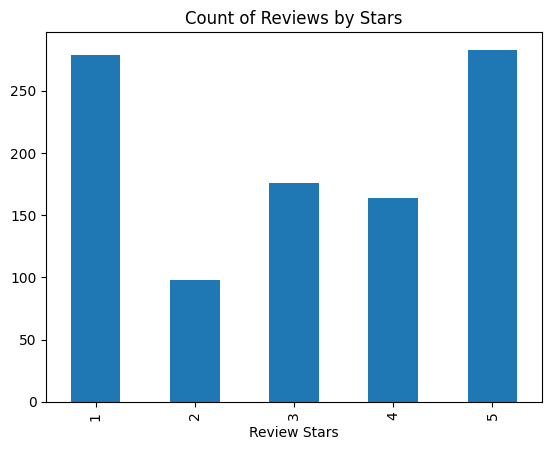

In [9]:
ax=df['rating'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars')
ax.set_xlabel('Review Stars')

I would expect the reviews to be normally distributed as in most other kinds of data, but the above bar plot shows that rating systems are uniquely distributed probably due to some inherent bias.

# Setting up Sentiment Analysis Models

In [10]:
example = df['review'][0] #defining example variable used to test sentiment analysis models
print(example)

Why does it look like someone spit on my food?
I had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.


In [11]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Why', 'does', 'it', 'look', 'like', 'someone', 'spit', 'on', 'my', 'food']

In [12]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Why', 'WRB'),
 ('does', 'VBZ'),
 ('it', 'PRP'),
 ('look', 'VB'),
 ('like', 'IN'),
 ('someone', 'NN'),
 ('spit', 'NN'),
 ('on', 'IN'),
 ('my', 'PRP$'),
 ('food', 'NN')]

In [13]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Why/WRB
  does/VBZ
  it/PRP
  look/VB
  like/IN
  someone/NN
  spit/NN
  on/IN
  my/PRP$
  food/NN
  ?/.
  I/PRP
  had/VBD
  a/DT
  normal/JJ
  transaction/NN
  ,/,
  everyone/NN
  was/VBD
  chill/NN
  and/CC
  polite/NN
  ,/,
  but/CC
  now/RB
  i/VBP
  dont/VBP
  want/VBP
  to/TO
  eat/VB
  this/DT
  ./.
  Im/NNP
  trying/VBG
  not/RB
  to/TO
  think/VB
  about/IN
  what/WP
  this/DT
  milky/NN
  white/clear/JJ
  substance/NN
  is/VBZ
  all/DT
  over/IN
  my/PRP$
  food/NN
  ,/,
  i/NN
  d/VBP
  */JJ
  */NNP
  */NNP
  sure/JJ
  am/VBP
  not/RB
  coming/VBG
  back/RB
  ./.)


# VADER Sentiment Scoring

This is the first sentiment analysis model I will be using, VADER (Valence Aware Dictionary and sEntiment Reasoner).

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

## Testing the polarity scores with example statements

In [14]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [15]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [16]:
sia.polarity_scores(example)

{'neg': 0.027, 'neu': 0.879, 'pos': 0.094, 'compound': 0.5215}

In [17]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    review = row['review']
    id = row['reviewer_id']
    res[id] = sia.polarity_scores(review)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'reviewer_id'})
vaders = vaders.merge(df, how = 'left')

In [19]:
vaders.head()

,reviewer_id,neg,neu,pos,compound,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,0.027,0.879,0.094,0.5215,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1
1,2,0.000,0.791,0.209,0.8687,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,0.051,0.949,0.000,-0.3535,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1
3,4,0.000,1.000,0.000,0.0000,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,5,0.143,0.857,0.000,-0.8020,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1


## VADER Results Plots

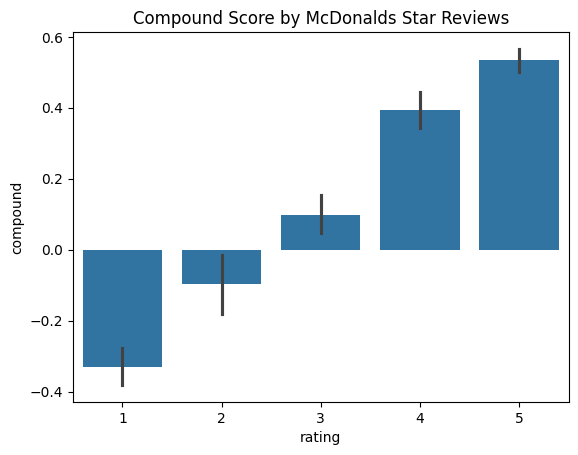

In [20]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compound Score by McDonalds Star Reviews')
plt.show()

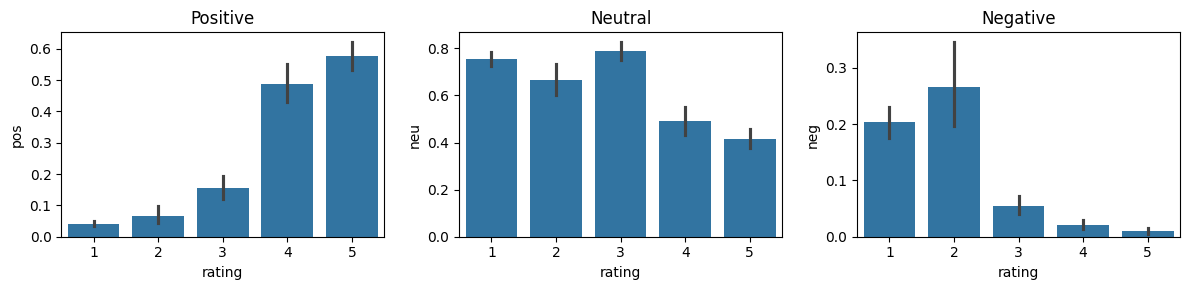

In [21]:
fig, axs = plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders, x='rating',y='pos',ax=axs[0])
sns.barplot(data=vaders, x='rating',y='neu',ax=axs[1])
sns.barplot(data=vaders, x='rating',y='neg',ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

This is the second model I will be using for sentiment intensity analysis, which will be compared with the VADER results from before.

In [22]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

ModuleNotFoundError: No module named 'transformers'

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
print(example)
sia.polarity_scores(example)

Why does it look like someone spit on my food?
I had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.


{'neg': 0.027, 'neu': 0.879, 'pos': 0.094, 'compound': 0.5215}

In [ ]:
#Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.96296793, 'roberta_neu': 0.033355895, 'roberta_pos': 0.0036761954}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        review = row['review']
        id = row['reviewer_id']
        vader_result = sia.polarity_scores(review)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(review)
        both = {**vader_result_rename, **roberta_result}
        res[id] = both
    except RuntimeError:
        print(f'Broke for id {id}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 63
Broke for id 75


In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'reviewer_id'})
results_df = results_df.merge(df, how = 'left')

## Comparing Scores between Models

In [ ]:
results_df.columns

Index(['reviewer_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'store_name', 'category',
       'store_address', 'latitude ', 'longitude', 'rating_count',
       'review_time', 'review', 'rating'],
      dtype='object')

## Combine and Compare

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


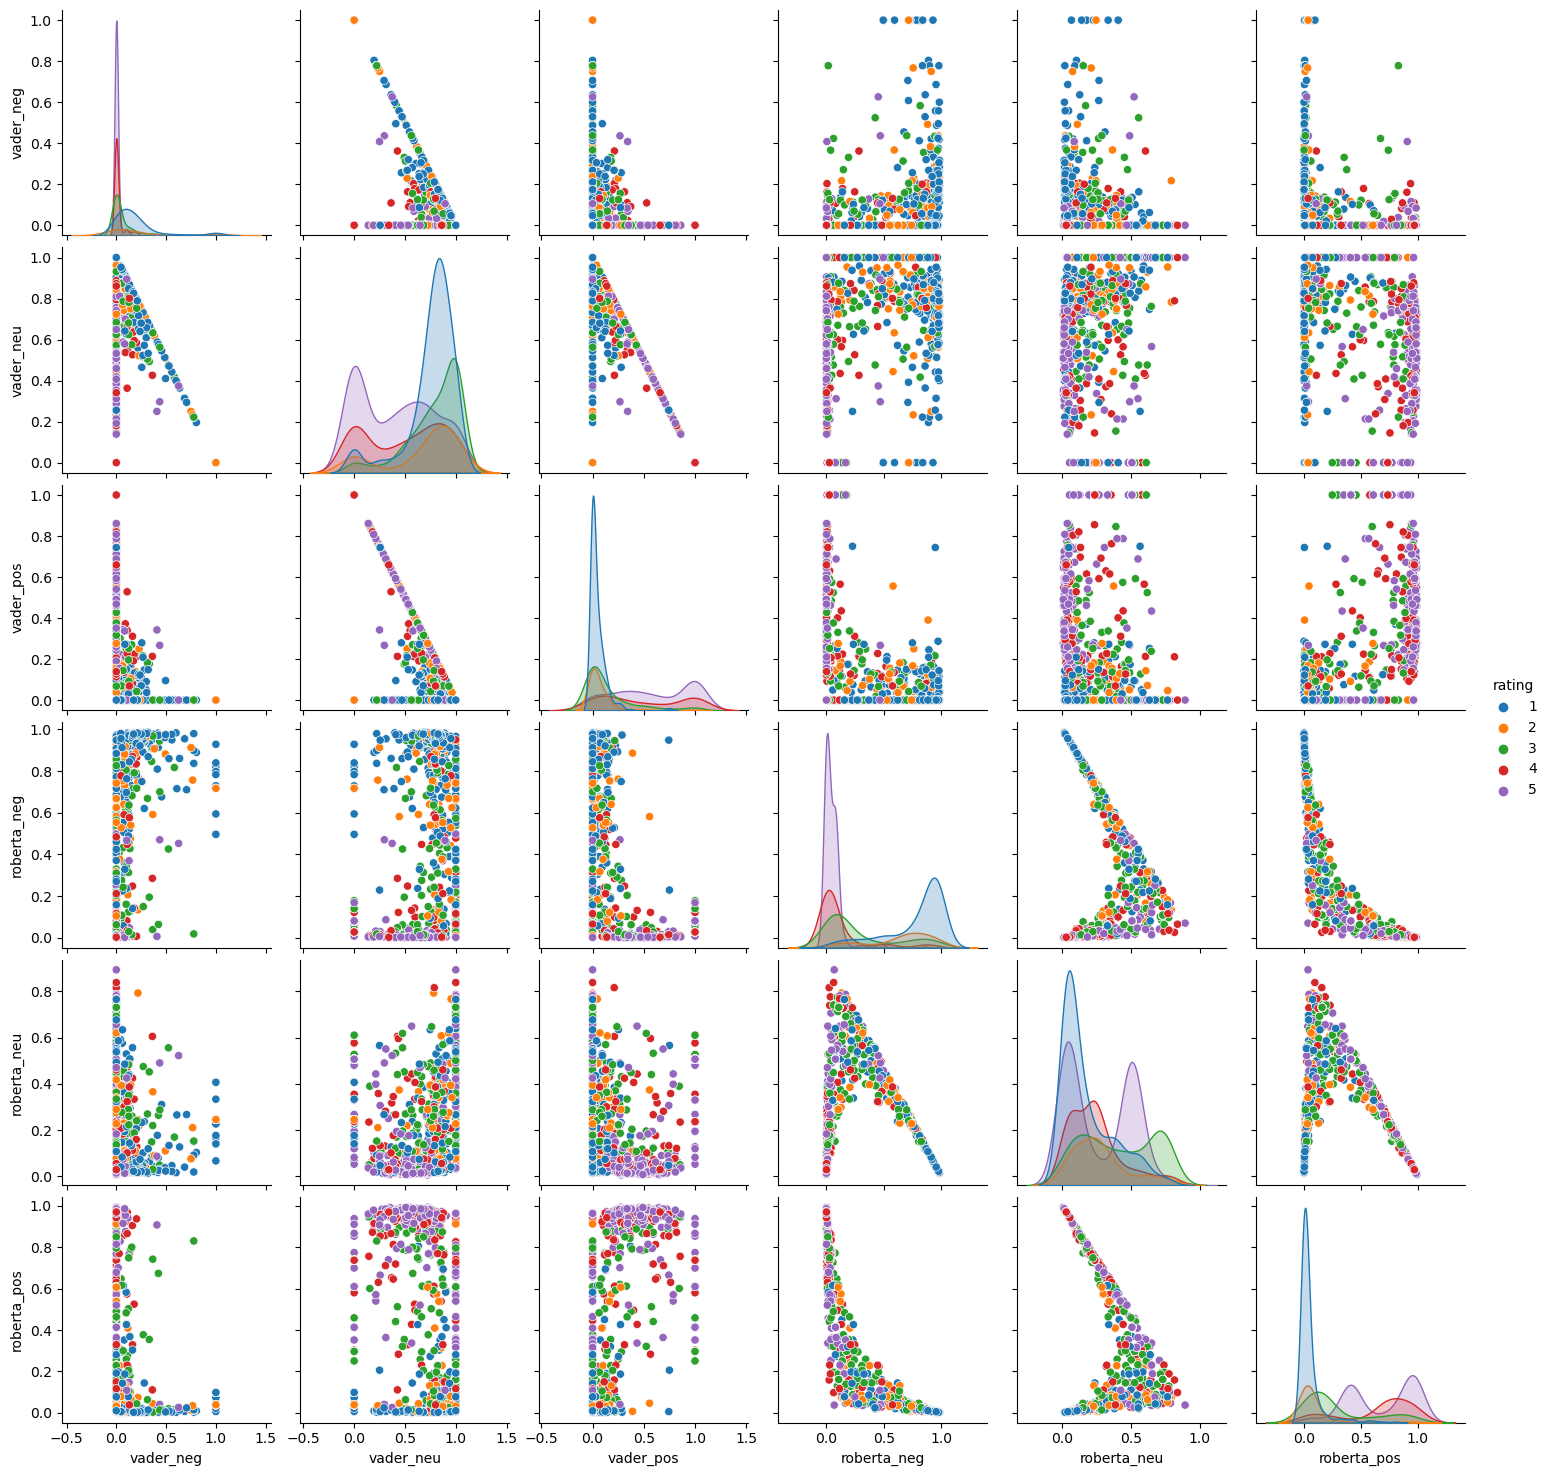

In [ ]:
sns.pairplot(data=results_df,
            vars = ['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = 'rating',
            palette = 'tab10')
plt.show()

# Review Examples

In [ ]:
# positive 1 star reviews
results_df.query('rating == 1') \
    .sort_values('roberta_pos', ascending = False)['review'].values[0]

'Staff is great ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½  except for the Fat m'

In [ ]:
# positive 1 star reviews
results_df.query('rating == 1') \
    .sort_values('vader_pos', ascending = False)['review'].values[0]

'Haha never'

In [ ]:
#negative 5 star reviews
results_df.query('rating == 5') \
    .sort_values('roberta_neg', ascending = False)['review'].values[0]

'so lit was dank'

In [ ]:
# positive 1 star reviews
results_df.query('rating == 1') \
    .sort_values('vader_neg', ascending = False)['review'].values[0]

'Bad'

# Transformers Pipeline

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
sent_pipeline('boooo')

[{'label': 'NEGATIVE', 'score': 0.756568193435669}]